In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.datasets import make_regression
import tensorflow as tf
from keras import backend as K
import itertools
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Layer, InputLayer, Reshape, Flatten, Conv1D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import plot_model, to_categorical
from custum_func import my_acc, my_loss, ExponentialLayer, ControlledDropoutLayer, dropout_conf_1, dropout_conf_2, dropout_conf_3, PowLayer, dropout_conf_4


2023-05-09 23:26:34.121301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 23:26:34.287124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-09 23:26:34.287156: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-09 23:26:35.199066: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
# load train_data

train_data = pd.read_csv(
    "../data_acquisition/data_0.3/training_standardized.csv", sep=";"
)

features = np.swapaxes(
    np.array(
        [
            train_data["home_xG"],
            train_data["home_xg_against"],
            train_data["away_xG"],
            train_data["away_xg_against"],
            train_data["home_xT_all"],
            train_data["home_xt_all_against"],
            train_data["away_xT_all"],
            train_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)

form = np.swapaxes(
    np.array(
        [
            (train_data["ha_form_home_for"]),
            (train_data["ha_form_home_against"]),
            (train_data["ha_form_away_for"]),
            (train_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(
    np.array([train_data["home_score"], train_data["away_score"]]), 0, 1
)

elo_diff = np.swapaxes(
    np.array([(train_data["elo_diff_home"]), (train_data["elo_diff_away"])]), 0, 1
)

X = np.concatenate([features, form, elo_diff], axis=1)
y = np.array(goals, dtype=float)

In [4]:
test_data = pd.read_csv(
    "../data_acquisition/data_0.3/test_standardized.csv", sep=";"
).dropna()


features = np.swapaxes(
    np.array(
        [
            test_data["home_xG"],
            test_data["home_xg_against"],
            test_data["away_xG"],
            test_data["away_xg_against"],
            test_data["home_xT_all"],
            test_data["home_xt_all_against"],
            test_data["away_xT_all"],
            test_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)

form = np.swapaxes(
    np.array(
        [
            (test_data["ha_form_home_for"]),
            (test_data["ha_form_home_against"]),
            (test_data["ha_form_away_for"]),
            (test_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(np.array([test_data["home_score"], test_data["away_score"]]), 0, 1)

elo = np.swapaxes(
    np.array([(test_data["elo_diff_home"]), (test_data["elo_diff_away"])]), 0, 1
)
X_test = np.concatenate([features, form, elo], axis=1)
y_test = np.array(goals, dtype=float)

In [5]:
X.resize((6082, 16))
X = X.reshape((6082, 4, 4))
X = X.reshape(list(X.shape) + [1])

test_shape = X_test.shape
X_test.resize((test_shape[0], 16))
X_test = X_test.reshape((test_shape[0], 4, 4))
X_test = X_test.reshape(list(X_test.shape) + [1])

In [55]:
X_test.shape

(1545, 4, 4)

In [158]:
dconf1, dconf2 = dropout_conf_1(cnn=True)
step_size = len(dconf1)
model = Sequential()
model.add(InputLayer(input_shape=(4, 4, 1)))
model.add(ControlledDropoutLayer(dconf1))
model.add(Conv2D(20, kernel_size=3, padding="valid"))
# model.add(MaxPooling2D((2,2)))
# # model.add(Flatten())
# # model.add(Reshape((4,4,1)))
# model.add(Conv2D(20, kernel_size=2, padding="valid"))
# # model.add(AveragePooling2D((2,2)))
# # model.add(Flatten())
# # model.add(Reshape((4,4,1)))
# model.add(Conv2D(64, kernel_size=2, padding="valid"))
model.add(Flatten())
model.add(ControlledDropoutLayer(dconf2))
model.add(Dense(2, activation="linear"))

In [159]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 controlled_dropout_layer_4   (None, 4, 4, 4)          0         
 (ControlledDropoutLayer)                                        
                                                                 
 conv2d_81 (Conv2D)          (None, 2, 2, 20)          740       
                                                                 
 flatten_57 (Flatten)        (None, 80)                0         
                                                                 
 controlled_dropout_layer_5   (None, 80)               0         
 (ControlledDropoutLayer)                                        
                                                                 
 dense_31 (Dense)            (None, 2)                 162       
                                                                 
Total params: 902
Trainable params: 902
Non-trainable

In [160]:
model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
hist = model.fit(X, y, epochs=50, steps_per_epoch=step_size, shuffle=True)

Epoch 1/50
127/127 [==============================] - 2s 9ms/step - loss: 2.5447 - my_acc: 0.4968
Epoch 2/50
127/127 [==============================] - 1s 9ms/step - loss: 1.7581 - my_acc: 0.5074
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 1.5938 - my_acc: 0.5142
Epoch 4/50
127/127 [==============================] - 1s 10ms/step - loss: 1.5929 - my_acc: 0.5078
Epoch 5/50
127/127 [==============================] - 1s 10ms/step - loss: 1.5902 - my_acc: 0.5095
Epoch 6/50
127/127 [==============================] - 1s 9ms/step - loss: 1.5883 - my_acc: 0.5081
Epoch 7/50
127/127 [==============================] - 1s 10ms/step - loss: 1.5931 - my_acc: 0.5056
Epoch 8/50
127/127 [==============================] - 1s 9ms/step - loss: 1.5876 - my_acc: 0.5080
Epoch 9/50
127/127 [==============================] - 1s 9ms/step - loss: 1.5886 - my_acc: 0.5088
Epoch 10/50
127/127 [==============================] - 1s 10ms/step - loss: 1.5866 - my_acc: 0.5063
Epoch 11/50
127

In [6]:
if True: # run cell or not
    run_size = 5
    run_params = []
    run_params.append(dropout_conf_1(cnn=True))
    run_params.append(dropout_conf_2(cnn=True))
    run_params.append(dropout_conf_3(cnn=True))
    dconf1, dconf2 = dropout_conf_1(cnn=True)
    tmp1, tmp2 = dropout_conf_2(cnn=True)
    dconf1 = np.concatenate([dconf1, tmp1])
    dconf2 = np.concatenate([dconf2, tmp2])
    run_params.append((dconf1, dconf2))
    dconf1, dconf2 = dropout_conf_1(cnn=True)
    tmp1, tmp2 = dropout_conf_3(cnn=True)
    dconf1 = np.concatenate([dconf1, tmp1])
    dconf2 = np.concatenate([dconf2, tmp2])
    run_params.append((dconf1, dconf2))
    dconf1, dconf2 = dropout_conf_2(cnn=True)
    tmp1, tmp2 = dropout_conf_3(cnn=True)
    dconf1 = np.concatenate([dconf1, tmp1])
    dconf2 = np.concatenate([dconf2, tmp2])
    run_params.append((dconf1, dconf2))
    dconf1, dconf2 = dropout_conf_1(cnn=True)
    tmp1, tmp2 = dropout_conf_2(cnn=True)
    tmp3, tmp4 = dropout_conf_3(cnn=True)
    dconf1 = np.concatenate([dconf1, tmp1, tmp3])
    dconf2 = np.concatenate([dconf2, tmp2, tmp4])
    run_params.append((dconf1, dconf2))

    dropout_version_df, test_acc_df, std_df, ece_h_df, ece_d_df, ece_a_df = [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)]

    for i in range(run_size):
        for d_idx, (dconf1, dconf2) in enumerate(run_params):
            step_size = len(dconf1)
            dropout_version_df[i].append(d_idx)
            model = Sequential()
            model.add(InputLayer(input_shape=(4, 4, 1)))
            model.add(ControlledDropoutLayer(dconf1))
            model.add(Conv2D(20, kernel_size=3, padding="valid"))
            model.add(Flatten())
            model.add(ControlledDropoutLayer(dconf2))
            model.add(Dense(2, activation="linear"))

            model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
            hist = model.fit(X, y, epochs=50, steps_per_epoch=step_size, shuffle=True)

            preds = []
            for x in range(step_size):
                preds.append(model(X_test))

            preds = np.stack(preds)
            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]
            home_std = np.std(predictions_home, axis=1)
            away_std = np.std(predictions_away, axis=1)

            std_df[i].append(((home_std.mean() + away_std.mean()) / 2))

            act_res = []
            for h, a in y_test:
                act_res.append(f"{str(int(h))}:{str(int(a))}")

            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

            game_quotes = []
            most_goals = {"home": [], "away": []}
            for game_idx in range(len(predictions_home)):
                game_df = pd.DataFrame(
                    {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
                )
                game_df["diff"] = game_df["home"] - game_df["away"]
                game_df["clipped_res"] = np.clip(game_df["diff"], -1, 1)
                game_df["rounded_res"] = np.rint(game_df["clipped_res"])
                home = game_df.loc[game_df["rounded_res"] == 1].shape[0] / step_size
                draw = (
                    game_df.loc[game_df["rounded_res"] == 0].shape[0] / step_size
                )
                away = game_df.loc[game_df["rounded_res"] == -1].shape[0] / step_size

                game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")

            df_res = pd.DataFrame(
                {"actual": act_res, "predicted": game_quotes}
            ) 
            df_cross = pd.DataFrame(
                {
                    "actual": [
                        0
                        if int(df_res.iloc[i]["actual"].split(":")[0])
                        > int(df_res.iloc[i]["actual"].split(":")[1])
                        else 1
                        if int(df_res.iloc[i]["actual"].split(":")[0])
                        == int(df_res.iloc[i]["actual"].split(":")[1])
                        else 2
                        for i in range(df_res.shape[0])
                    ],
                    "pred": [
                        np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                        for i in range(df_res.shape[0])
                    ],
                    "pred_val": [
                        np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                        for i in range(df_res.shape[0])
                    ],
                    "bookie": [
                        np.argmax(
                            [
                                test_data.iloc[i].bookie_home,
                                test_data.iloc[i].bookie_draw,
                                test_data.iloc[i].bookie_away,
                            ]
                        )
                        for i in range(test_data.shape[0])
                    ],
                    "bookie_val": [
                        np.max(
                            [
                                test_data.iloc[i].bookie_home,
                                test_data.iloc[i].bookie_draw,
                                test_data.iloc[i].bookie_away,
                            ]
                        )
                        for i in range(test_data.shape[0])
                    ],
                }
            )
            right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
            home_pred = {"act_away": 0, "act_draw": 0}
            draw_pred = {"act_away": 0, "act_home": 0}
            away_pred = {"act_home": 0, "act_draw": 0}
            for x in range(df_cross.shape[0]):
                if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
                    if df_cross.iloc[x]["pred"] == 0:
                        if df_cross.iloc[x]["actual"] == 1:
                            home_pred["act_draw"] += 1
                        else:
                            home_pred["act_away"] += 1
                    elif df_cross.iloc[x]["pred"] == 1:
                        if df_cross.iloc[x]["actual"] == 0:
                            draw_pred["act_home"] += 1
                        else:
                            draw_pred["act_away"] += 1
                    else:
                        if df_cross.iloc[x]["actual"] == 0:
                            away_pred["act_home"] += 1
                        else:
                            away_pred["act_draw"] += 1
                    wrong += 1
                else:
                    if df_cross.iloc[x]["actual"] == 0:
                        home_right += 1
                    elif df_cross.iloc[x]["actual"] == 1:
                        draw_right += 1
                    else:
                        away_right += 1
                    right += 1

            home_wrong = home_pred["act_away"] + home_pred["act_draw"]
            draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
            away_wrong = away_pred["act_home"] + away_pred["act_draw"]
            acc = right / df_cross.shape[0]
            test_acc_df[i].append(acc)
            
            # ece
            data_length = df_cross.shape[0]
            acc_home = (
                df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 0].shape[0]
            acc_draw = (
                df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 1].shape[0]
            acc_away = (
                df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 2].shape[0]

            conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
            conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
            conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
            ece_h_df[i].append(abs(acc_home - conf_home))
            ece_d_df[i].append(abs(acc_draw - conf_draw))
            ece_a_df[i].append(abs(acc_away - conf_away))

    auswertung = pd.DataFrame({"dropout_conf": np.mean(dropout_version_df, axis=0), "test_acc": np.mean(test_acc_df, axis=0), "std": np.mean(std_df, axis=0), "ece_h": np.mean(ece_h_df, axis=0), "ece_d": np.mean(ece_d_df, axis=0), "ece_a": np.mean(ece_a_df, axis=0)})
    auswertung.head(10)

2023-05-09 23:26:44.108865: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-09 23:26:44.108884: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-09 23:26:44.108897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (morten-thinkpad): /proc/driver/nvidia/version does not exist
2023-05-09 23:26:44.109055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
127/127 [==============================] - 2s 9ms/step - loss: 2.6469 - my_acc: 0.4775
Epoch 2/50
127/127 [==============================] - 1s 9ms/step - loss: 1.7567 - my_acc: 0.4991
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 1.5924 - my_acc: 0.5032
Epoch 4/50
127/127 [==============================] - 2s 13ms/step - loss: 1.5925 - my_acc: 0.5058
Epoch 5/50
127/127 [==============================] - 2s 12ms/step - loss: 1.5936 - my_acc: 0.5068
Epoch 6/50
127/127 [==============================] - 2s 13ms/step - loss: 1.5907 - my_acc: 0.5045
Epoch 7/50
127/127 [==============================] - 2s 12ms/step - loss: 1.5919 - my_acc: 0.5050
Epoch 8/50
127/127 [==============================] - 2s 13ms/step - loss: 1.5903 - my_acc: 0.5125
Epoch 9/50
127/127 [==============================] - 2s 13ms/step - loss: 1.5939 - my_acc: 0.5059
Epoch 10/50
127/127 [==============================] - 2s 12ms/step - loss: 1.5830 - my_acc: 0.5109
Epoch 11/50


In [7]:
auswertung.head(10)

,dropout_conf,test_acc,std,ece_h,ece_d,ece_a
0,0.0,0.445825,0.513605,0.171899,0.072509,0.441003
1,1.0,0.528932,1.426963,0.021467,0.241793,0.160186
2,2.0,0.558317,3.148118,0.032131,0.247789,0.180919
3,3.0,0.437540,0.582619,0.189236,0.078019,0.471528
4,4.0,0.434434,1.602286,0.146344,0.119276,0.516489
5,5.0,0.531650,2.442760,0.071697,0.103010,0.293435
6,6.0,0.386019,1.392091,0.253015,0.046996,0.532898


In [151]:
model.evaluate(X_test, y_test)

49/49 [==============================] - 0s 1ms/step - loss: 1.3240 - my_acc: 0.5553


[1.3240039348602295, 0.555342972278595]

In [125]:
preds = []
for x in range(1000):
    preds.append(model(X_test, training=True))

preds = np.stack(preds)
# preds = preds.astype(int)

In [126]:
predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

In [127]:
home_std = np.std(predictions_home, axis=1)
away_std = np.std(predictions_away, axis=1)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe989a9e9e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe989a9fd30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe989a9c880>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe989a9fc10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe989a9d990>],
 'means': []}

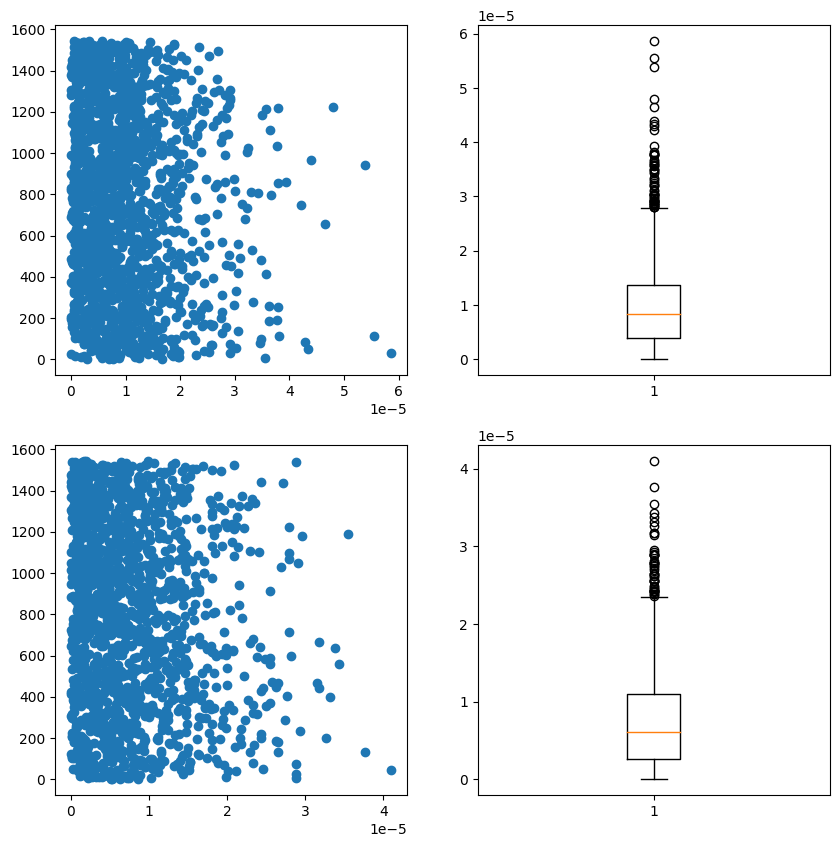

In [128]:
fig, (ax1, ax2) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
ax1[0].scatter(home_std, np.arange(1545))
ax2[0].scatter(away_std, np.arange(1545))
ax1[1].boxplot(home_std)
ax2[1].boxplot(away_std)

In [129]:
act_res = []
for h, a in y_test:
    act_res.append(f"{str(int(h))}:{str(int(a))}")

predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    game_df = pd.DataFrame(
        {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
    )
    # home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6])
    # away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6])
    # home, draw, away = 0, 0, 0
    # for i in range(len(home_hist)):
    #     for j in range(len(away_hist)):
    #         if j < i:
    #             home += (home_hist[i]/1000) * (away_hist[j]/1000)
    #         elif j == i:
    #             draw += (home_hist[i]/1000) * (away_hist[j]/1000)
    #         elif j > i:
    #             away += (home_hist[i]/1000) * (away_hist[j]/1000)
    game_df["diff"] = game_df["home"] - game_df["away"]
    home = game_df.loc[game_df["diff"] >= 1].shape[0] / 1000
    draw = (
        game_df.loc[(game_df["diff"] < 1) & (game_df["diff"] > -1)].shape[0] / 1000
    )
    away = game_df.loc[game_df["diff"] <= -1].shape[0] / 1000

    game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")
    # most_goals["home"].append(f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%")
    # most_goals["away"].append(f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%")

# df_res = pd.DataFrame({"actual": act_res, "predicted": game_quotes, "prob goals home" : most_goals['home'], "prob goals away" : most_goals['away']})
df_res = pd.DataFrame(
    {"actual": act_res, "predicted": game_quotes}
)  # , "prob goals home" : most_goals['home'], "prob goals away" : most_goals['away']})
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[i]["actual"].split(":")[0])
            > int(df_res.iloc[i]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[i]["actual"].split(":")[0])
            == int(df_res.iloc[i]["actual"].split(":")[1])
            else 2
            for i in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data.shape[0])
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data.shape[0])
        ],
    }
)

In [130]:
df_res.head(20)

,actual,predicted
0,1:1,1.0-0.0-0.0
1,1:0,0.0-1.0-0.0
2,2:0,1.0-0.0-0.0
3,2:1,1.0-0.0-0.0
4,0:1,0.0-1.0-0.0
5,2:1,0.0-1.0-0.0
6,1:1,0.0-0.0-1.0
7,2:2,1.0-0.0-0.0
8,1:2,0.0-0.0-1.0
9,2:1,0.0-0.0-1.0


In [131]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

Verteilung:
Anzahl Predicted Home: 436 (28.22%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 903 (58.45%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 206 (13.33%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 776 (50.23%), Anzahl Falsch: 769 (49.77%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 324 (49.02%), Anzahl Home Falsch: 112
Home Pred. aber Draw --> 68
Home Pred. aber Away --> 44
Anzahl Draw Korrekt: 292 (74.11%), Anzahl Draw Falsch: 611
Draw Pred. aber Home --> 325
Draw Pred. aber Away --> 286
Anzahl Away Korrekt: 160 (32.65%), Anzahl Away Falsch: 46
Away Pred. aber Home --> 12
Away Pred. aber Draw --> 34


In [104]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        np.array(predictions_home[game_idx], dtype=int), [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        np.array(predictions_away[game_idx], dtype=int), [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

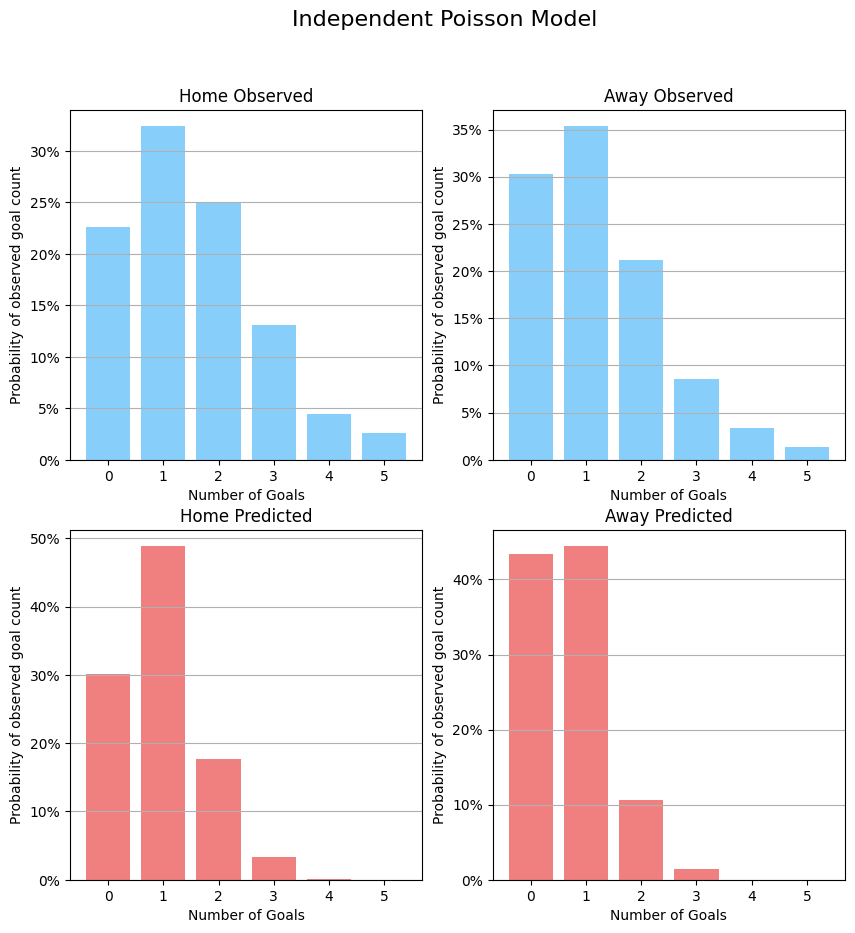

In [105]:
his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
fig, (ax1, ax2) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
fig.suptitle("Independent Poisson Model", fontsize=16)
ax1[0].bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
ax1[0].set_title("Home Observed")
ax1[0].set_xlabel("Number of Goals")
ax1[0].set_ylabel("Probability of observed goal count")
ax1[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[0].grid(axis="y")

ax2[0].bar(
    np.arange(len(home_cum_hist)),
    home_cum_hist / np.sum(home_cum_hist),
    color="lightcoral",
)
ax2[0].set_title("Home Predicted")
ax2[0].set_xlabel("Number of Goals")
ax2[0].set_ylabel("Probability of observed goal count")
ax2[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[0].grid(axis="y")

ax1[1].bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
ax1[1].set_title("Away Observed")
ax1[1].set_xlabel("Number of Goals")
ax1[1].set_ylabel("Probability of observed goal count")
ax1[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[1].grid(axis="y")

ax2[1].bar(
    np.arange(len(away_cum_hist)),
    away_cum_hist / np.sum(away_cum_hist),
    color="lightcoral",
)
ax2[1].set_title("Away Predicted")
ax2[1].set_xlabel("Number of Goals")
ax2[1].set_ylabel("Probability of observed goal count")
ax2[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[1].grid(axis="y")

In [83]:
print("observed")
print(np.mean(train_data.home_score))
print(np.mean(train_data.away_score))

observed
1.5348569549490299
1.2387372574810918


In [84]:
print(np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist))
print(np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist))

0.9035598705501618
0.9003236245954692


Text(0.5, 1.0, 'Predicted')

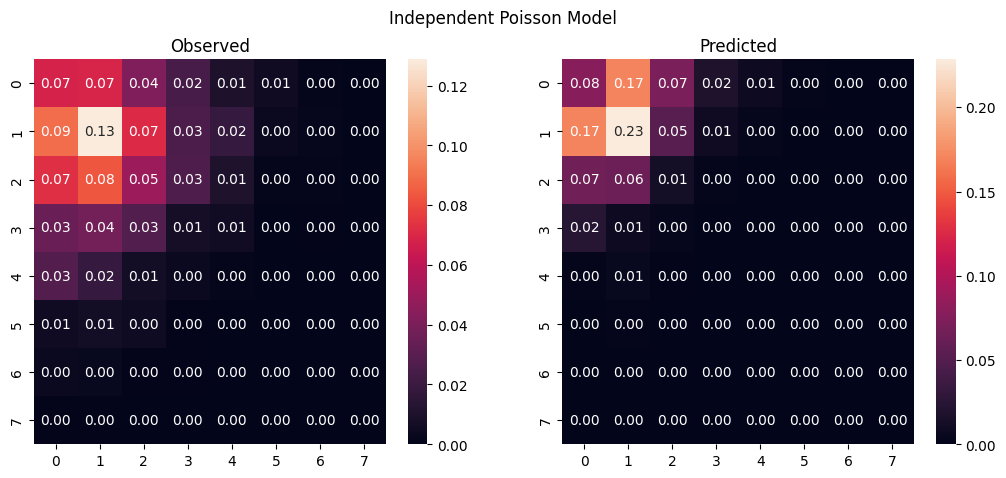

In [85]:
# actual
max_goals = int(np.max(y_test)) + 1
res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
for h, a in y_test:
    res_table_a[int(h)][int(a)] += 1
res_table_a = res_table_a / test_data.shape[0]

# predicted
max_goals = int(np.max(y_test)) + 1
res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

game_quotes = []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    probs = probs
    res_table_p += probs

res_table_p = res_table_p / test_data.shape[0]

# sb.heatmap(res_table_p, annot=True)

# top pred result:
max_goals = int(np.max(y_test)) + 1
res_table_pr = np.array([np.zeros(max_goals) for _ in range(max_goals)])

game_quotes = []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    res_table_pr[np.argmax(home_hist)][np.argmax(away_hist)] += 1
res_table_pr = res_table_pr / test_data.shape[0]
# sb.heatmap(res_table_pr, annot=True)

fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))
fig.suptitle("Independent Poisson Model")
sb.heatmap(ax=axes[0], data=res_table_a, annot=True, fmt=".2f")
axes[0].set_title("Observed")
sb.heatmap(ax=axes[1], data=res_table_p, annot=True, fmt=".2f")
axes[1].set_title("Predicted")

In [86]:
print(np.tril(res_table_a).sum() - np.trace(res_table_a))
print(np.trace(res_table_a))
print(np.triu(res_table_a).sum() - np.trace(res_table_a))

0.4278317152103559
0.25501618122977343
0.31715210355987045


In [87]:
print(np.tril(res_table_p).sum() - np.trace(res_table_p))
print(np.trace(res_table_p))
print(np.triu(res_table_p).sum() - np.trace(res_table_p))

0.3449838187702265
0.3190938511326861
0.33592233009708733


In [88]:
# ece
data_length = df_cross.shape[0]

# acc_model = np.sum(df_cross['actual'] == df_cross['pred']) / data_length
# acc_bookie = np.sum(df_cross['bookie'] == df_cross['actual']) / data_length

# print("Accuracy Model: ", acc_model)
# print("Accuracy Bookie: ", acc_bookie)

# conf_model = np.sum(df_cross['pred_val']) / data_length
# conf_bookie = np.sum(df_cross['bookie_val']/100) / data_length

# print("Confidence Model: ", conf_model)
# print("Confidence Bookie: ", conf_bookie)

# ece_model = np.mean(np.absolute(acc_model - conf_model))
# ece_bookie = np.mean(np.absolute(acc_bookie - conf_bookie))

# print(f"Model ECE: {ece_model}")
# print(f"Bookie ECE: {ece_bookie}")
acc_home = (
    df_cross.loc[(df_cross["bookie"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["bookie"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["bookie"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["bookie"] == 0)].bookie_val / 100)
conf_draw = np.mean(df_cross.loc[(df_cross["bookie"] == 1)].bookie_val / 100)
conf_away = np.mean(df_cross.loc[(df_cross["bookie"] == 2)].bookie_val / 100)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)


acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)

0.2601783491155203
nan
0.06721056586652263
-0.6686838124054463
-0.20050761421319796
-0.6040816326530613


In [89]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 1545
won: 728
lost: 817
money:  4356.900000000002
